# SAR example
Let's use EOReader with SAR data.

<div class="alert alert-warning">
  
<strong>Warning:</strong> SAR data is processed with <a href="https://step.esa.int/main/download/snap-download/">SNAP</a>, so be sure to have it installed and that <code>GPT</code> is in your path. 
    
</div>

## Create logger

In [1]:
# Create logger
import logging

logger = logging.getLogger("eoreader")
logger.setLevel(logging.INFO)

# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)

# create formatter
formatter = logging.Formatter('%(message)s')

# add formatter to ch
ch.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)

## Open the COSMO-SkyMed product

Please be aware that:
- **EOReader** will orthorectify your SAR data to get UTM tiles.
- complex data is not handled as is, **EOReader** will convert them to ground range.

In [2]:
import os
from eoreader.reader import Reader

# First of all, we need some VHR data, let's use some COSMO-SkyMed data
path = os.path.join("/home", "data", "DATA", "PRODS", "COSMO", "1st_GEN", "1001512-735097")

# Open your product
prod = Reader().open(path, remove_tmp=True)
prod

EOReader CskProduct
Attributes:
	condensed_name: 20201008T224018_CSK_HI_DGM
	name: CSKS4_DGM_B_HI_09_HH_RA_FF_20201008224018_20201008224025
	path: /home/data/DATA/PRODS/COSMO/1st_GEN/1001512-735097
	platform: COSMO-SkyMed
	sensor type: SAR
	product type: DGM
	default resolution: 5.0
	acquisition datetime: 2020-10-08T22:40:18.446381
	band mapping:
		VV: VV
		VV_DSPK: VV_DSPK
		HH: HH
		HH_DSPK: HH_DSPK
		VH: VH
		VH_DSPK: VH_DSPK
		HV: HV
		HV_DSPK: HV_DSPK
		RH: RH
		RH_DSPK: RH_DSPK
		RV: RV
		RV_DSPK: RV_DSPK
	tile name: N/A
	needs_extraction: True

Acquisition datetime: 2020-10-08 22:40:18.446381
Condensed name: 20201008T224018_CSK_HI_DGM
Executing processing graph
.Copernicus_DSM_COG_10_N15_00_E108_00_DEM.tif
...10%....20%....30%....40%....50%....60%....70%....80%....90% done.


<AxesSubplot:>

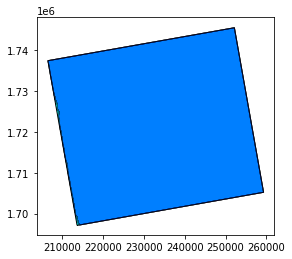

In [3]:
# Print some data
print(f"Acquisition datetime: {prod.datetime}")
print(f"Condensed name: {prod.condensed_name}")

# Open here some more interesting geographical data: extent and footprint
extent = prod.extent()
footprint = prod.footprint()
base = extent.plot(color='cyan', edgecolor='black')
footprint.plot(ax=base, color='blue', edgecolor='black', alpha=0.5)

For SAR data, the footprint needs the orthorectified data !
For that, SNAP uses its own DEM, but you can change it when positionning the `EOREADER_SNAP_DEM_NAME` environment variable. 
Available DEMs are:
- `ACE2_5Min` 
- `ACE30`
- `ASTER 1sec GDEM`
- `Copernicus 30m Global DEM`(buggy for now, do not use it)
- `Copernicus 90m Global DEM`(buggy for now, do not use it)
- `GETASSE30` (by default)
- `SRTM 1Sec HGT`
- `SRTM 3Sec`
- `External DEM`

<div class="alert alert-warning">
  
<strong>Warning:</strong> 
   If `External DEM` is set, you must specify the DEM you want by positioning the `EOREADER_DEM_PATH` to a DEM that can be read by SNAP.
</div>
    
## Load bands

In [4]:
from eoreader.bands import *
from eoreader.env_vars import DEM_PATH

# Set the DEM
os.environ[DEM_PATH] = os.path.join("/home", "data", "DS2", "BASES_DE_DONNEES", "GLOBAL", "COPDEM_30m", "COPDEM_30m.vrt")

# Select some bands you wish to load without knowing if they exist
bands = [VV, HH, VV_DSPK, HH_DSPK, HILLSHADE, SLOPE]

# Only keep those selected
ok_bands = [band for band in bands if prod.has_band(band)]

# This product does not have VV band and HILLSHADE band cannot be computed from SAR band
print(to_str(ok_bands))

['HH', 'HH_DSPK', 'SLOPE']


In [5]:
# Load those bands as a dict of xarray.DataArray, with a 20m resolution
band_dict = prod.load(ok_bands, resolution=20.)
band_dict[HH]

Executing processing graph
first_line_time metadata value is null
last_line_time metadata value is null
...10%...21%...32%...43%...54%...65%...76%...87%. done.


<xarray.DataArray 'HH' (band: 1, y: 2474, x: 2689)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 2.058e+05 2.059e+05 ... 2.596e+05 2.596e+05
  * y            (y) float64 1.746e+06 1.746e+06 ... 1.697e+06 1.697e+06
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:      1.0
    add_offset:        0.0
    long_name:         HH
    sensor:            COSMO-SkyMed
    sensor_id:         CSK
    product_path:      /home/data/DATA/PRODS/COSMO/1st_GEN/1001512-735097
    product_name:      CSKS4_DGM_B_HI_09_HH_RA_FF_20201008224018_20201008224025
    product_filename:  1001512-735097
    product_type:      DGM
    acquisition_date:  20201008T224018
    condensed_name:    20201008T224018_CSK_HI_DGM

<div class="alert alert-info">
Some SAR band (i.e. COSMO) may contain null pixels that are not really nodata (but very low values like water).  
    
This can lead the Terrain Correction step to create large nodata area when projecting on a DEM.
    
If it happens, you can set the keyword <code>SAR_INTERP_NA</code> to <code>True</code> when loading or stacking SAR data to fill these area with interpolated data.
</div>

```python
from eoreader.keywords import SAR_INTERP_NA
band_dict = prod.load(
    ok_bands, 
    resolution=20., 
    **{SAR_INTERP_NA: True}
)
```

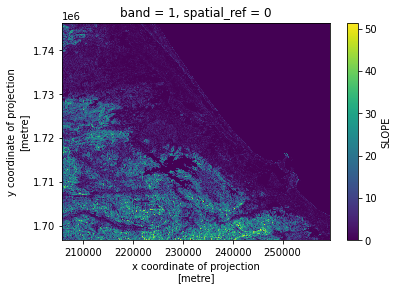

In [6]:
# Plot a subsampled version
band_dict[SLOPE][:, ::10, ::10].plot()

## Stack some data

In [7]:
# You can also stack those bands
stack = prod.stack(ok_bands)
stack

<xarray.DataArray 'HH HH_DSPK SLOPE' (z: 3, y: 9897, x: 10755)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 0.4255329 ,  0.4255329 ,  0.4255329 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.4255329 ,  0.4255329 ,  0.4255329 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.4255329 ,  0.4255329 ,  0.4255329 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [16.66219   , 16.66219   , 16.66219   , ...,  0.0870695 ,
          0.0870695 ,  0.0870695 ],
        [16.66219   , 16.66219   , 16.66219   , ...,  0.0870695 ,
          0.0870695 ,  0.0870695 ],
        [17.018255  , 17.018255  , 17.018255  , ...,  0.08737368,
          0.08737368,  0.08737368]]], dtype=float32)
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 2.058e+05 2.058e+05 ... 2.596e+05 2.596e+05
  * y            (y) float64 1.746e+06 1.746e+06 ... 1.697e+06 1.697e+06
  * z            (z) MultiIndex
  - variable     (z) object 'HH' 'HH_DSPK' 'SLOPE'
  - band         (z) int64 1 1 1
Attributes:
    long_name:         HH HH_DSPK SLOPE
    sensor:            COSMO-SkyMed
    sensor_id:         CSK
    product_path:      /home/data/DATA/PRODS/COSMO/1st_GEN/1001512-735097
    product_name:      CSKS4_DGM_B_HI_09_HH_RA_FF_20201008224018_20201008224025
    product_filename:  1001512-735097
    product_type:      DGM
    acquisition_date:  20201008T224018
    condensed_name:    20201008T224018_CSK_HI_DGM

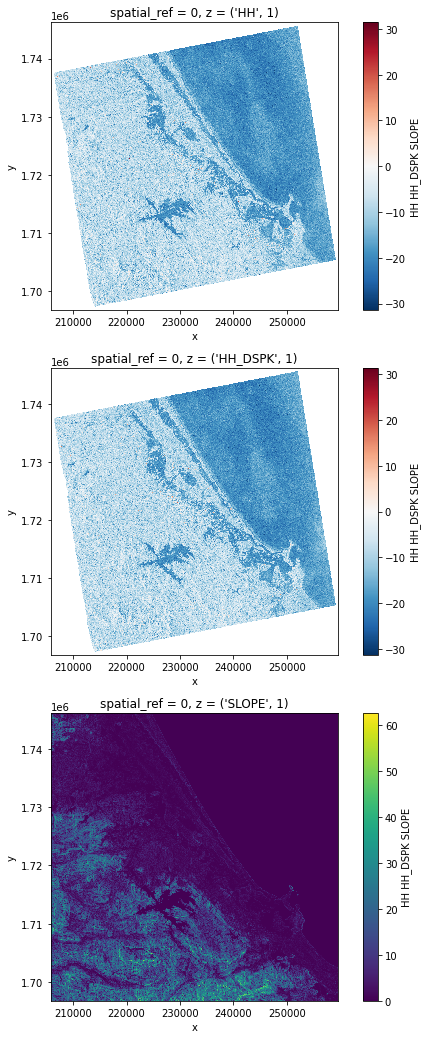

In [8]:
# Plot a subsampled version
import matplotlib.pyplot as plt

nrows = len(stack)
fig, axes = plt.subplots(nrows=nrows, figsize=(3 * nrows, 6 * nrows), subplot_kw={"box_aspect": 1})
for i in range(nrows):
    stack[i, ::10, ::10].plot(x="x", y="y", ax=axes[i])